# 数据增广

数据增强
- 增加一个已有数据集，使得有更多的多样性
  - 在语音里面加入各种不同的背景噪音
  - 改变图片的颜色和形状

使用增强数据**训练**
- **在线生成**
- 可能是**随机增强**

翻转
- 左右翻转
- 上下反装
  - 不总是可行（取决于数据集）

切割
- 从图片中切割一块，然后变形到固定形状
  - 随机高宽比 (e.g.[3/4, 4/3])
  - 随机大小 (e.g.[8%, 100%])
  - 随机位置

颜色
- 改变色调，饱和度，明亮度 (e.g.[0.5, 1..5])

几十中其他办法


### 总结
- 数据增广通过变形数据来获取多样性，从而使得模型泛化性能更好
- 常见图片增光包括翻转、切割、变色
- 为在预测过程中得到确切的结果，通常只对训练样本进行图像增广，而在预测过程不使用带随机操作的图像增广

### 注意：
- MixUp：通过将两张图像以及对应的标签进行加权混合来生成新的训练样本，从而增强模型的泛化能力
  - 生成`(image_mix, label_mix)`
  - 是一种简单而有效的数据增强方式，可以显著提高模型的泛化能力，并被广泛应用于各类图像分类任务中

- 数据增广的本质：增加训练数据的多样性，使其**更加接近模型在真实应用中可能遇到的测试数据分布**

## 代码

In [ ]:
!pip install d2l

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from d2l import torch as d2l

**挂载Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


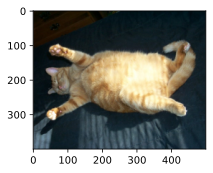

In [ ]:
d2l.set_figsize()
img = d2l.Image.open('/content/drive/MyDrive/Colab Notebooks/img/cat1.jpg')
plt.imshow(img)

```
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_rows * scale, num_cols * scale)
  _, axis = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axis.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if isinstance(img, list):
      img = img[0]
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  plt.show()
```

**定义函数`apply`**

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
  Y = [aug(img) for i in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

**翻转、剪裁**
- `torchvision.transforms.RandomHorizontalFlip()`
- `torchvision.transforms.RandomVerticalFlip()`
- `torchvision.transforms.RandomResizedCrop(size, scale, ratio)`：其中`ratio`控制剪裁区域的宽高比范围

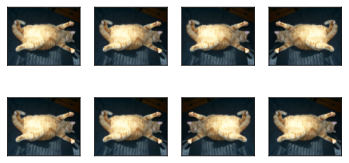

In [ ]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

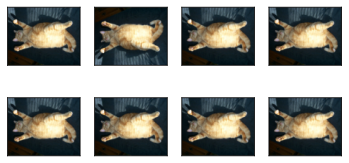

In [ ]:
apply(img, torchvision.transforms.RandomVerticalFlip())

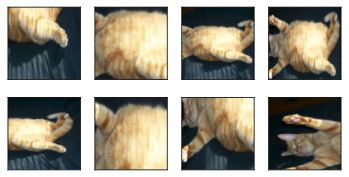

In [ ]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

**改变颜色——亮度、色调、对比度、饱和度**

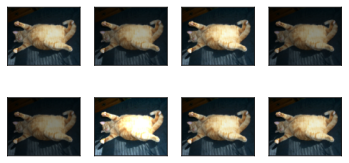

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))

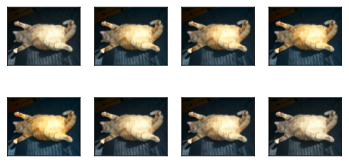

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0.5, hue=0
))

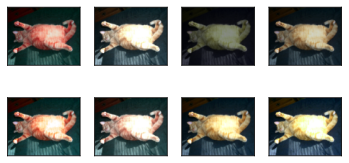

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0/5, saturation=0.5, hue=0.1
))

**结合多种图像增广方法**
- `torchvision.transforms.Compose`

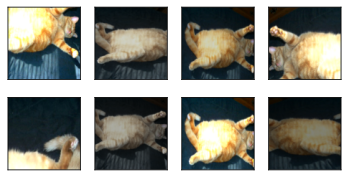

In [ ]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0/5, saturation=0.5, hue=0)

augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug
])
apply(img, augs)

#### 使用图像增广进行**训练**
- 使用**CIFAR-10**数据集，其对象的颜色和大小差异更明显($32\times32$)
- `torchvision.datasets.CIFAR10`数据样本的结果是一个**元组**`(image, label)`

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

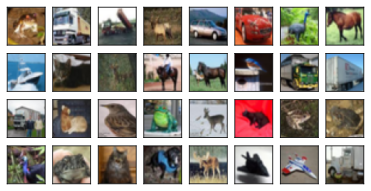

In [ ]:
all_images = torchvision.datasets.CIFAR10(train=True, root='..\data', download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

**只对训练样本进行图像增广，这里只使用最简单的随机左右翻转**

In [ ]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

**定义一个辅助函数，以便于读取图像和应用图像增广**

In [ ]:
def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root='../data', train=is_train, transform=augs, download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=is_train, num_worker=2)
  return dataloader

**多GPU训练**

```
def try_all_gpus():
  devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
  return devices if devices else [torch.device('cpu')]
```

In [ ]:
def train_batch_ch13(net, X, y, loss, trianer, devices):
  if isinstance(X, list):
    X = [x.to(devices[0] for x in X)]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

- **`.to(devices[0])`**说明将整个主副本放在`devices[0]`

In [ ]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, lr, devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(
      xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
      legend=['train loss', 'train acc', 'test acc']
  )
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop

      # 每隔 num_batches // 5 个批次执行一次，或者在最后一个批次执行
      if (i + 1) % (num_batches // 5) or i == num_batches - 1:
        animator.add(
            epoch + (i + 1) / num_batches,
            (metric[0] / metric[2], metric[1] / metric[3], None)
        )
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')


**定义`train_with_data_aug`函数，使用图像增广来训练模型**
- `torch.optim.Adam`对学习率没有那么敏感（相对于`SGD`）

In [ ]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_agus, net, lr=0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction='none')
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

**无图像增强**

In [ ]:
train_with_data_aug(test_augs, test_augs, net)

### 练习


In [1]:
!pip install d2l

In [2]:
import torch
import torchvision

from torch import nn
from d2l import torch as d2l

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import hashlib
import os
import requests
import tarfile
import zipfile

data_dir_drive = '/content/drive/My Drive/ColabData/'

def download(name, cache_dir=os.path.join(data_dir_drive, 'data')):
  assert name in DATA_HUB, f"{name}不存在于{DATA_HUB}中。"
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()  # 创建一个SHA-1哈希对象
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)  # 以每次 1 MB 的块大小读取
        if not data:  # data为空，文件读取完毕
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname # 文件已经存在且完整
  print(f'正在从{url}下载{fname}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

def download_extract(name, folder=None):
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    with zipfile.ZipFile(fname, 'r') as z:
      z.extractall(base_dir)  # 解压`zip`文件中所有内容，并放在`base_dir`路径下
  elif ext in ('.tar', '.gz'):
    with tarfile.open(fname, 'r') as t:
      t.extractall(base_dir)
  else:
    raise ValueError('只有zip/tar文件可以被解压缩。')
  return os.path.join(base_dir, folder) if folder else data_dir

d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
DATA_HUB = d2l.DATA_HUB

# data_dir = download_extract('hotdog')

data_dir = download_extract('hotdog')
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

print(data_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ColabData/data/hotdog


**注意**

- `torch.utils.data.DataLoader`的输入需要是一个**`Dataset`对象**，此对象必须实现`__len__`和`__getitem__`方法
  - `torchvision.datasets, torchtext.datasets, torchaudio.datasets`中的标准数据集都可以直接被`DataLoader`使用
  - 通过`torch.utils.data.TensorDataset`得到`Dataset`对象
    - `TensorDataset`接受任意数量的张量作为输入，要求每个张量的第一个维度大小必须相同




In [ ]:
all_images = torchvision.datasets.CIFAR10(train=True, root='../data', download=True)

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

def apply(img, aug, num_rows, num_cols, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root='../data', train=is_train,
                      transform=augs, download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=2)
  return dataloader

def train_batch_ch13(net, X, y, loss, trainer, devices):
  """用多GPU进行小批量训练"""
  if isinstance(X, list):
    X = [x.to(devices[0]) for x in X]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])

  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(
    xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
    legend=['train loss', 'train acc', 'test acc']
  )
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {metric[0] / metric[2]:.3f}, train acc '
        f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
        f'{str(devices)}')

batch_size = 256
devices = d2l.try_all_gpus()
net = d2l.resnet18(10, 3)

def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv2d):
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

def train_with_data_augs(train_augs, test_augs, net, lr=0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction='none')
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified


In [ ]:
train_with_data_augs(test_augs, test_augs, net)

In [ ]:
train_with_data_augs(train_augs, test_augs, net)

1. 在基于CIFAR-10数据集的模型训练中结合多种不同的图像增广方法，能提高测试准确性吗？

In [ ]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(-10, 10),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])

train_with_data_aug(train_augs, test_augs, net)

2. 其他图像增广方法
- 裁剪
  - `transforms.CenterCrop`
  - `transforms.RandomCrop`
  - `transforms.RandomResizedCrop`
- 翻转和旋转
  - `transforms.RandomHotrizontalFlip`
  - `transforms.RandomVerticalFlip`
  - `transforms.RandomRotation`
- 图像变换
  - `transforms.Normlize`
  - `transforms.ToTensor`：转为tensor，并归一化到[0, 1]
  - `transforms.ColorJitter`
  - `transforms.Pad`
  - `transforms.Grayscale`
  - `transforms.LinearTransformation`
  - `transforms.RandomAffine`
  - `transforms.RandomGrayscale`
  - ...
